# Time Series Forecasting

```{article-info}
:avatar: https://avatars.githubusercontent.com/u/25820201?v=4
:avatar-link: https://github.com/PhotonicGluon/
:author: "[Ryan Kan](https://github.com/PhotonicGluon/)"
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
```

*This notebook is largely inspired from Jason Brownlee's [LSTM time series prediction article](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) on Machine Learning Mastery.*

In this example, we will do time series forecasting using Keras-MML's Gated Recurrent Unit (GRU) and Linear Recurrent Unit (LRU) implementations.

:::{important}
We will be using some dataset processing and plotting utilities for this notebook. Run the command below to install them, then reload the kernel.
:::

In [1]:
%pip install pandas~=2.2.2 scikit-learn~=1.5.0 matplotlib~=3.9.0 seaborn~=0.13.2

Note: you may need to restart the kernel to use updated packages.


## Preparing the Data

### Loading the Data

The dataset we will be using is the airline passengers dataset in George E. P. Box's book *Time Series Analysis: Forecasting and Control* (see Chapter 9, Series G). This dataset is included in R as the [`AirPassengers` dataset](https://rdrr.io/r/datasets/AirPassengers.html), and it can be downloaded below.

```{button-link} https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
:color: primary
:shadow:

Download Data
```

This dataset contains 144 observations of airline passenger counts from January 1949 to December 1960 (i.e. 12 years). The passenger counts are in terms of 1000 passengers, so a value of `123` means 123,000 passengers.

The dataset is saved in the file called `airline-passengers.csv` in the folder `data`. We load it in using the Pandas library.

In [2]:
import pandas as pd

df = pd.read_csv("data/airline-passengers.csv", usecols=["Passengers"])

Let's take a look at the time series that we will be working with.

<Axes: >

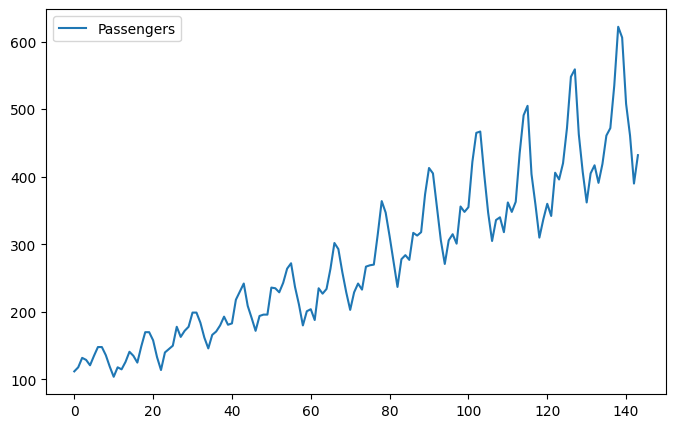

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(df)

We can see an upward trend over time, and some periodicity that could correspond to vacation periods during the year.

### Preprocessing the Data

Let's now perform some simple preprocessing on the dataset.

First, ensure that all the values in the dataset are expressed as floats (and not integers).

In [4]:
dataset = df.values
dataset = dataset.astype("float32")

Next, normalize the dataset to be in the interval $[0, 1]$.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

We will use 80% of the data for training and the other 20% for testing.

In [6]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]

print(len(train), len(test))

115 29


We want to provide the model some past data (specifically, `LOOK_BACK` days worth of data) and then ask it to predict the following day's passenger count.

In [7]:
LOOK_BACK = 3

In [8]:
import numpy as np


def create_dataset(dataset, look_back=1):
    x, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : i + look_back, 0]
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)


train_X, train_Y = create_dataset(train, LOOK_BACK)
test_X, test_Y = create_dataset(test, LOOK_BACK)

Keras RNNs require the input to be of the shape `(batch, timesteps, features)`, so we will reshape the input to match this. Since we are just using the passenger counts, we only have one feature to include.

In [9]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

## Gated Recurrent Unit (GRU) Model

The GRU is an alternative to the traditional Long Short-Term Memory (LSTM) unit. Despite having a much simpler structure than LSTMs, the performance of GRUs are comparable to LSTMs. The implementation of GRUs in Keras-MML also lends them to being easily parallelized, hence improving the speed of training.

In [10]:
import keras
import keras_mml

2024-06-25 05:53:23.247541: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 05:53:23.249875: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 05:53:23.280623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 05:53:24.158481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The GRU model architecture that we will be using is very rudimentary: we just attach a `Dense` head to the `GRUMML` layer for the prediction output. We will aim to minimise MSE loss using the Adam optimizer.

In [11]:
model = keras.Sequential()
model.add(keras.Input((LOOK_BACK, 1)))
model.add(keras_mml.layers.GRUMML(4))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])

We define a callback to print the training output once every 10 epochs. This is to reduce clutter on the screen.

In [12]:
class print_training_results_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if int(epoch) % 10 == 0:
            print(
                f"Epoch: {epoch:>3}"
                + f" | loss: {logs['loss']:.5f}"
                + f" | mae: {logs['mae']:.5f}"
                + f" | val_loss: {logs['val_loss']:.5f}"
                + f" | val_mae: {logs['val_mae']:.5f}"
            )

With all that setup, we can train the model!

In [13]:
model.fit(
    train_X,
    train_Y,
    epochs=200,
    batch_size=1,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, min_delta=1e-4, verbose=1),
        print_training_results_Callback(),
    ],
    verbose=0,
)

Epoch:   0 | loss: 0.08052 | mae: 0.24688 | val_loss: 0.18739 | val_mae: 0.42108
Epoch:  10 | loss: 0.01660 | mae: 0.10555 | val_loss: 0.09703 | val_mae: 0.29545
Epoch:  20 | loss: 0.01445 | mae: 0.09857 | val_loss: 0.08495 | val_mae: 0.27589
Epoch:  30 | loss: 0.00859 | mae: 0.07354 | val_loss: 0.03902 | val_mae: 0.17966
Epoch:  40 | loss: 0.00277 | mae: 0.03970 | val_loss: 0.00928 | val_mae: 0.07497
Epoch:  50 | loss: 0.00219 | mae: 0.03642 | val_loss: 0.00566 | val_mae: 0.06147
Epoch:  60 | loss: 0.00211 | mae: 0.03706 | val_loss: 0.00558 | val_mae: 0.06116
Epoch:  70 | loss: 0.00213 | mae: 0.03738 | val_loss: 0.00525 | val_mae: 0.05992
Epoch:  80 | loss: 0.00208 | mae: 0.03610 | val_loss: 0.00513 | val_mae: 0.05917
Epoch 86: early stopping


How did the model do?

In [14]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Un-normalize the predictions
train_pred_orig = scaler.inverse_transform(train_pred)
train_Y_orig = scaler.inverse_transform([train_Y])
test_pred_orig = scaler.inverse_transform(test_pred)
test_y_orig = scaler.inverse_transform([test_Y])

# Then evaluate the MSE
train_score = np.sqrt(mean_squared_error(train_Y_orig[0], train_pred_orig[:, 0]))
print(f"Train MSE: {train_score:.2f}")
test_score = np.sqrt(mean_squared_error(test_y_orig[0], test_pred_orig[:, 0]))
print(f"Test MSE:  {test_score:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train MSE: 26.79
Test MSE:  68.21


Let's also see how the predictions look like.

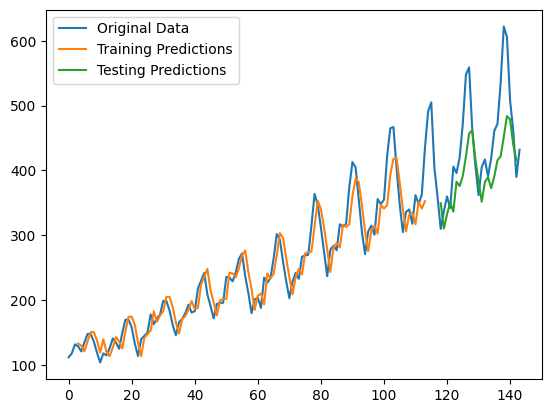

In [15]:
# Shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:, :] = np.nan
train_pred_plot[LOOK_BACK : len(train_pred) + LOOK_BACK, :] = train_pred_orig

# Shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + (LOOK_BACK * 2) + 1 : len(dataset) - 1, :] = test_pred_orig

# Plot the baselines and the predictions
plt.plot(scaler.inverse_transform(dataset), label="Original Data")
plt.plot(train_pred_plot, label="Training Predictions")
plt.plot(test_pred_plot, label="Testing Predictions")
plt.legend()
plt.show()

## Linear Recurrent Unit (LRU) Model

[*Resurrecting Recurrent Neural Networks for Long Sequences*](https://arxiv.org/pdf/2303.06349v1) by Orvieto et al. introduces an alternative to the GRU &mdash; the LRU. It essentially uses two linear matrix recurrence relations to mimic recurrent units using complex numbers, and this lends it to be easily implemented using regular `Dense` (and thus the Keras-MML `DenseMML`) layers.

The architecture of the LRU model is similar to that of the GRU model above, except that we specify the *state dimension*, which we will take to be `8` here.

In [16]:
model = keras.Sequential()
model.add(keras.Input((LOOK_BACK, 1)))
model.add(keras_mml.layers.LRUMML(4, 8))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [17]:
model.fit(
    train_X,
    train_Y,
    epochs=200,
    batch_size=1,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, min_delta=1e-4, verbose=1),
        print_training_results_Callback(),
    ],
    verbose=0,
)

Epoch:   0 | loss: 0.00472 | mae: 0.05091 | val_loss: 0.01350 | val_mae: 0.09610
Epoch:  10 | loss: 0.00227 | mae: 0.03942 | val_loss: 0.00566 | val_mae: 0.06247
Epoch:  20 | loss: 0.00208 | mae: 0.03701 | val_loss: 0.00592 | val_mae: 0.06309
Epoch:  30 | loss: 0.00205 | mae: 0.03660 | val_loss: 0.00621 | val_mae: 0.06460
Epoch:  40 | loss: 0.00257 | mae: 0.03927 | val_loss: 0.00563 | val_mae: 0.06200
Epoch 46: early stopping


We now evaluate the LRU model.

In [18]:
# Make predictions
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Un-normalize the predictions
train_pred_orig = scaler.inverse_transform(train_pred)
train_Y_orig = scaler.inverse_transform([train_Y])
test_pred_orig = scaler.inverse_transform(test_pred)
test_y_orig = scaler.inverse_transform([test_Y])

# Then evaluate the MSE
train_score = np.sqrt(mean_squared_error(train_Y_orig[0], train_pred_orig[:, 0]))
print(f"Train MSE: {train_score:.2f}")
test_score = np.sqrt(mean_squared_error(test_y_orig[0], test_pred_orig[:, 0]))
print(f"Test MSE:  {test_score:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train MSE: 26.60
Test MSE:  51.00


What does the LRU's predictions look like?

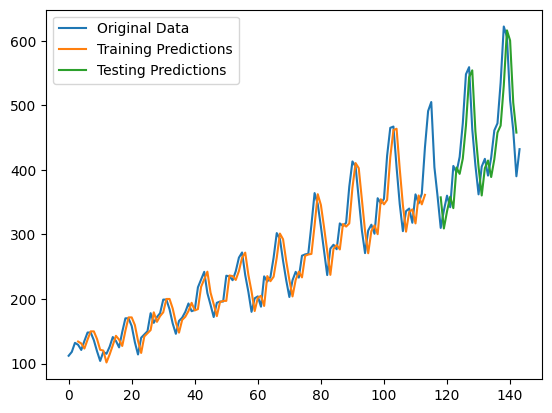

In [19]:
# Shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:, :] = np.nan
train_pred_plot[LOOK_BACK : len(train_pred) + LOOK_BACK, :] = train_pred_orig

# Shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + (LOOK_BACK * 2) + 1 : len(dataset) - 1, :] = test_pred_orig

# Plot the baselines and the predictions
plt.plot(scaler.inverse_transform(dataset), label="Original Data")
plt.plot(train_pred_plot, label="Training Predictions")
plt.plot(test_pred_plot, label="Testing Predictions")
plt.legend()
plt.show()

## Conclusion

In this notebook, we demonstrated how to use Keras-MML's `GRUMML` and `LRUMML` for time series forecasting. They act as suitable replacements for the traditional `LSTM` layer, and they use dramatically less matrix multiplication operations than normal.